In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from stingray import Lightcurve
import binaryCorr
import copy
import glob,os
import numpy as np
import scipy
import astropy.io.fits as fits
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('science')
plt.rcParams['text.usetex'] = True
from astropy.table import Table
from astropy.modeling import models
import stingray
from stingray.gti import create_gti_from_condition, create_gti_mask, gti_border_bins, time_intervals_from_gtis, cross_two_gtis
from stingray.utils import show_progress
from stingray.fourier import avg_cs_from_events, avg_pds_from_events, poisson_level, get_average_ctrate
from stingray import AveragedPowerspectrum, AveragedCrossspectrum, EventList
from stingray.modeling.parameterestimation import PSDLogLikelihood
from scipy.optimize import curve_fit
#from sklearn.mixture import GaussianMixturet
from sklearn import mixture
from sklearn.cluster import KMeans
# sphinx_gallery_thumbnail_number = 2
import emd, vmdpy
from scipy import signal, ndimage
from scipy import interpolate
import stingray.pulse as STpulse
from stingray.pulse.search import epoch_folding_search, z_n_search, phase_dispersion_search
from scipy.interpolate import CubicSpline

In [2]:
def hxbary(input,output,orbitfile):
        header = pyfits.open(input)[1].header
        # if header['OBS_MODE'] != 'Pointing':
        #     print('The Pointing mode is required!')
        #     #os.sys.exit()
        ra = header['RA_OBJ']
        dec = header['DEC_OBJ']
        print(ra,dec)
        os.system("hxbary  evtfile=%s  orbitfile=%s  ra=%lf  dec=%lf eph=2 clobber=yes"%(evt, orbitfile,  ra, dec))
        #print("barycorr ra=%s dec=%s refframe=ICRS infile=%s outfile=%s orbitfiles=%s"%(ra,dec,input,output,orbitfile))
        #Ephemeris (1 for DE200,2 for DE405)"

def read_lc(lc_file):
    lc_data = fits.open(lc_file)
    lc = lc_data[1].data['RATE']
    time = lc_data[1].data['TIME']
    start = lc_data[1].header['TSTART']
    timedel=lc_data[1].header['timedel']
    error = lc_data[1].data['ERROR']
    GTI0 = lc_data[2].data['START']
    GTI1 = lc_data[2].data['STOP']
    GTI = np.vstack([GTI0, GTI1])
    GTI = GTI.T
    lc_data.close()
    # time=time+start
    return time, lc, error, GTI, timedel
    
def efold_search(time, cts, prange, ref=0, cts_err = None, nbins = 16, dt = 1):
    def const(x, a):
        return a    
    time = time - ref
    chi2 = np.zeros(len(prange))
    for i, p in enumerate(prange):
#         print(i)
        bin_phase, bin_cts, bin_cts_err = efold(time, cts, p, nbins = nbins, dt = dt, cts_err = cts_err)
        #---
        popt, pcov = curve_fit(const, bin_phase, bin_cts, sigma = bin_cts_err, p0 = [bin_cts.mean()])
        model = popt[0]
        chi2[i] = (((model - bin_cts) / bin_cts_err)**2).sum()        
    #---------------------------
    return prange, chi2
    
def efold(time, cts, period, nbins = 16, dt = 1, cts_err = None):
    phase = STpulse.pulse_phase(time, 1./period)    
    phase_ind = phase // (1./nbins)
    mk = [phase_ind == j for j in range(nbins)]    
    #---
    bin_time = np.array([len(cts[mk[k]]) * dt for k in range(nbins)])
    #---    
    if cts_err is None:    
        bin_cts = np.array([cts[mk[k]].sum() for k in range(nbins)])
        bin_cts_err = np.sqrt(bin_cts)

        bin_cts = bin_cts/bin_time
        bin_cts_err = bin_cts_err/bin_time
    else:
        bin_cts = np.array([cts[mk[k]].sum() for k in range(nbins)])
        bin_cts_err = np.array([np.sqrt((cts_err[mk[k]]**2).sum()) for k in range(nbins)])

        bin_cts = bin_cts/bin_time
        bin_cts_err = bin_cts_err/bin_time  
    
    #---
    bin_phase = np.linspace(0, 1, nbins + 1)
    bin_phase = (bin_phase[1:] + bin_phase[:-1])/2.    
    return bin_phase, bin_cts, bin_cts_err#unit: cts/s
    
def subtract_pulse(t,rate0):
    dp = 104**2/(t.max()-t.min())/2./3.
    print(dp)
    prange = np.arange(102, 105, dp) #explain why
    # efolding method, an example for binned data
    print(len(t),len(rate0))
    prange, chi2 = efold_search(t, rate0, prange, ref=0, cts_err = error0, nbins = 16, dt = 1)
    period = prange[np.argmax(chi2)]
    print(period)
    #step 2: fold the light curve to pulse profile
    phase_bins, profile, profile_err=efold(t, rate0, period, nbins = 128, dt = 1, cts_err = error0)
    rms=(profile.max()-profile.min())/(profile.max()+profile.min())
    print(rms)
    #step 3: Use interpolated to build a continuous function of the pulse profile 
    # 假设你有一些观测值
    x_observed = phase_bins
    y_observed = profile
    # 使用观测值创建三次样条插值对象
    cubic_spline = CubicSpline(x_observed, y_observed)

    #step 4: get the count rate at any phase

    phase = STpulse.pulse_phase(t, 1./period)
    # 获取任意 x 位置点的 y 值
    x_position = phase
    y_interpolated = cubic_spline(x_position)

    #step 4: subtract pulse from light curve:
    rate_unpulse=rate0-y_interpolated+np.mean(rate0)
    return period, rate_unpulse

In [3]:
#obsid=20201127
path='/Volumes/WD_BLACK/Data/1A0535p262/HXMT/date_combine'
lc_files=glob.glob('%s/*/P*/HE/*25_80_net.lc'%path)
lcs=[]
for i in lc_files:
    time0, rate0, error0, GTI, dt = read_lc(i)
    mk = rate0 > 0
    lc = Lightcurve(time0[mk], rate0[mk], input_counts=False, dt = dt,gti=GTI)
    if dt==1.0:
        lcs.append(lc)

In [4]:
len(lcs),len(lc_files)

(242, 254)

In [5]:
mjdref=fits.open(lc_files[0])[1].header['MJDREFI']+fits.open(lc_files[0])[1].header['MJDREFF']

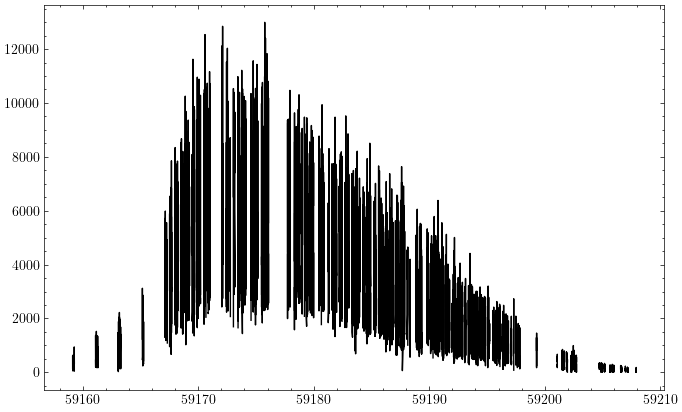

In [6]:
fig, axs = plt.subplots(1,1,figsize=(8, 5))
i=0
OBSIDS=[]
while i < len(lcs):
    MJDOBS=mjdref+fits.open(lc_files[i])[1].header['tstart']/86400.
    OBSID=fits.open(lc_files[i])[1].header['OBS_ID']
    EXPID=fits.open(lc_files[i])[1].header['EXP_ID']
    EXPO=fits.open(lc_files[i])[1].header['exposure']
    if float(EXPO) > 1000 and MJDOBS > 59150:
    #if float(EXPO) > 0:
        axs.plot(lcs[i].time/86400.+mjdref, lcs[i].countrate,'-k')
        mean_rate=np.mean(lcs[i].countrate)
        OBSIDS.append([mean_rate,float(MJDOBS),OBSID,EXPID, EXPO])
    #axs.legend()
    i+=1

In [7]:
len(OBSIDS)

171

In [8]:
#plt.subplots_adjust(hspace=0)
OBSIDS = sorted(OBSIDS, key=lambda x: x[1])
files_new=[]
for i in OBSIDS:
    print(i[0],i[1],i[2],i[3],int(i[4]))

262.2908 59159.13166300926 P0304099001 P030409900101-20201106-01-01 4851
561.8424 59161.11753106482 P0304099002 P030409900201-20201108-01-01 4867
517.6648 59161.29599171296 P0304099002 P030409900202-20201108-01-01 1354
775.11975 59163.042467407715 P0304099003 P030409900301-20201110-01-01 4192
796.1846 59163.217322731485 P0304099003 P030409900302-20201110-01-01 1660
1158.9716 59165.167467407504 P0304099004 P030409900401-20201112-01-01 1725
2749.9248 59167.14262365741 P0304099005 P030409900501-20201114-01-01 2848
2981.896 59167.52334125 P0314316001 P031431600102-20201114-01-01 4449
3194.2876 59167.65582967593 P0314316001 P031431600103-20201114-01-01 2046
3751.231 59168.00181347223 P0314316001 P031431600105-20201114-01-01 1466
3437.52 59168.06864217593 P0314316001 P031431600106-20201115-02-01 2683
3747.011 59168.185760231485 P0314316001 P031431600107-20201115-02-01 1181
3940.3716 59168.47720120371 P0314316001 P031431600109-20201115-02-01 2307
3978.7349 59168.583202361115 P0314316001 P0314

In [9]:
%%capture
lc_files_filter=[]
for i in OBSIDS:
    exp_id=i[3]
    #print(exp_id)
    lc_file=glob.glob('%s/*/%s/HE/*25_80_net.lc'%(path,exp_id))
    lc_files_filter.append(lc_file[0])
lcs_filter=[]
for i in lc_files_filter:
    time0, rate0, error0, GTI, dt = read_lc(i)
    mk = rate0 > 0
    lc = Lightcurve(time0[mk],rate0[mk], dt = dt,gti=GTI, input_counts=False)
    lcs_filter.append(lc)
    # try:
    #     period, rate_unpulse=subtract_pulse(time0,rate0)
    #     if period > 102:
    #         mk = rate_unpulse > 0
    #         lc = Lightcurve(time0[mk],rate_unpulse[mk], dt = dt,gti=GTI, input_counts=False)
    #         lcs_filter.append(lc)
    #     else:
    #         pass
    # except:
    #     pass
j=0
while j < len(lcs_filter):
    #print(lc_files_filter[j])
    if j == 0:
        lc_new=lcs_filter[0]
    if j > 0:
        lc_new=lc_new.join(lcs_filter[j])
    j+=1

# #exposure=1.116e+04
# time0, rate0, error0=lc_new.time,lc_new.countrate,lc_new.countrate_err

In [10]:
time, rate, error=lc_new.time,lc_new.countrate,lc_new.countrate_err

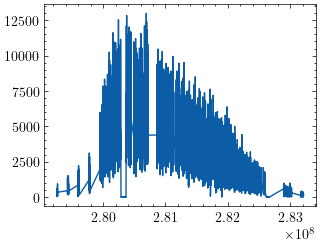

In [11]:
plt.plot(time,rate)

In [12]:
#gti0 = create_gti_from_condition(lc_new.time, lc_new.counts > 0, safe_interval=1)
new_gti1 = create_gti_mask(lc_new.time,lc_new.gti,min_length=200, return_new_gtis=True)
#new_gti1 = create_gti_mask(lc_new.time,gti0,min_length=500, return_new_gtis=True)
new_gti1 = new_gti1[1]
lc_new.gti=new_gti1
lc_new.apply_gtis()
LC = lc_new.split_by_gti(gti=new_gti1)

In [13]:
len(LC)

422

In [17]:
%%capture
DPS=[]
j=0
while j < len(LC):
    print(j)
    try:
        dps = stingray.DynamicalPowerspectrum(lc=LC[j], segment_size=100, norm='leahy',dt=1.0)
        DPS.append(dps)
    except:
        pass
    j+=1

In [15]:
print(DPS[0].time[0]/86400+mjdref)
print(DPS[-1].time[-1]/86400+mjdref)

59159.132247500005
59204.926593564815


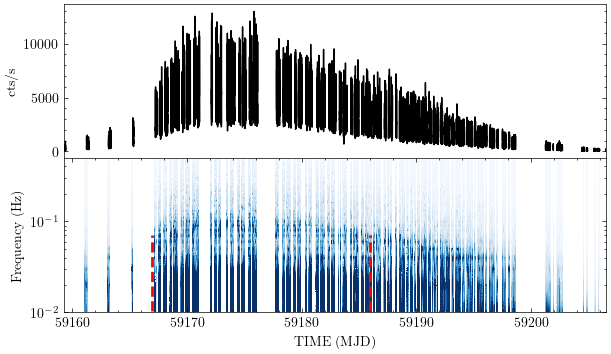

In [16]:
fig, axs = plt.subplots(2,1,figsize=(7, 4))
for j in LC:
    time1_ref=j.time/86400.+mjdref
    axs[0].plot(time1_ref, j.countrate,'-k')
for j in DPS:
    try:
        time2_ref=j.time/86400.+mjdref
        xx, yy = np.meshgrid(time2_ref,j.freq)
        axs[1].contourf(xx,yy,j.dyn_ps,50,cmap='Blues',vmin=2, vmax=3e3)
    except:
        pass
axs[0].set_xlim(DPS[0].time[0]/86400+mjdref,DPS[-1].time[-1]/86400+mjdref)
#axs[1].set_xlim(DPS[0].time[0]/86400+mjdref,DPS[-1].time[-1]/86400+mjdref)
axs[0].set_xticks([])
#axs[1].set_xticks([])
axs[1].set_yscale('log')    
axs[0].set_ylabel('cts/s')
axs[1].set_ylabel('Frequency (Hz)')
axs[1].set_xlabel('TIME (MJD)')
axs[1].axvline(59167,min(j.freq),0.5,linewidth = 2, linestyle ="--", 
            color ='red')
axs[1].axvline(59186,min(j.freq),0.5,linewidth = 2, linestyle ="--", 
            color ='red')
plt.subplots_adjust(hspace=0,wspace=0)
plt.show()

In [1]:
dynspec = stingray.DynamicalPowerspectrum(lc=LC[107], segment_size=200, norm='leahy')

NameError: name 'stingray' is not defined

In [23]:
#find time interval
intervals1=[0]
n=0
while n < len(LC)-1:
    interval1=LC[n+1].time[0]-LC[n].time[-1]
    intervals1.append(interval1)    
    n+=1
intervals_new1=[0]
i=1
while i < len(intervals1):
    inter=sum(intervals1[:i+1])
    intervals_new1.append(inter)
    i+=1
intervals1=intervals_new1

intervals2=[0]
n=0
while n < len(DPS)-1:
    interval2=DPS[n+1].time[0]-DPS[n].time[-1]
    intervals2.append(interval2)    
    n+=1
intervals_new2=[0]
i=1
while i < len(intervals2):
    inter=sum(intervals2[:i+1])
    intervals_new2.append(inter)
    i+=1
intervals2=intervals_new2

TypeError: Input z must be 2D, not 1D

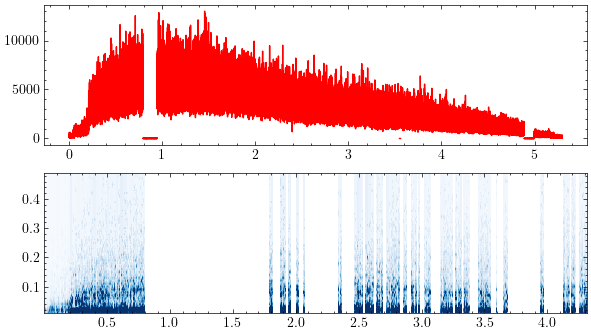

In [27]:
fig, axs = plt.subplots(2,1,figsize=(7, 4))
#for i,j in zip(intervals1,LC1):
#    time1=(j.time-i)/86400.+56658.00077759259
#    time1_ref=time1-(LC1[0].time[0]/86400.+56658.00077759259)
#    axs[0].plot(time1_ref, j.countrate,'-k')
    #axs[0].axvline(x=time1_ref[0],ls='--',color='red',alpha=0.3)
    #axs[0].axvline(x=time1_ref[-1],ls='--',color='red',alpha=0.3)
for i,j in zip(intervals1,LC):
    time1=(j.time-i)/86400.+mjdref
    time1_ref=time1-(LC[0].time[0]/86400.+mjdref)
    axs[0].plot(time1_ref, j.countrate,'-r',label='1.0-3.0 keV')
    #axs[0].axvline(x=time1_ref[0],ls='--',color='red',alpha=0.3)
    #axs[0].axvline(x=time1_ref[-1],ls='--',color='red',alpha=0.3)
for i,j in zip(intervals1,DPS):
    time2=(j.time-i)/86400.+mjdref
    #time2=(j.time)/86400.+56658.00077759259
    time2_ref=time2-(LC[0].time[0]/86400.+mjdref)
    xx, yy = np.meshgrid(time2_ref,j.freq)
    #print(j.dyn_ps)
    #extent = min(j.time), max(j.time), max(j.freq), min(j.freq)
    #axs[1].imshow(j.dyn_ps, vmin=0, vmax=0.1,interpolation="none", extent=extent)
    #axs[1].imshow(j.dyn_ps)
    axs[1].contourf(xx,yy,j.dyn_ps-2,50,cmap='Blues',vmin=2, vmax=3e3)
    #axs[1].contourf(xx,yy,j.dyn_ps-2,50,cmap='Blues')
    #axs[1].axvline(x=time2_ref[0],ls='--',color='red',alpha=0.3)
    #axs[1].axvline(x=time2_ref[-1],ls='--',color='red',alpha=0.3)    
axs[0].set_xticks([])
#axs[1].set_xticks([])
axs[1].set_yscale('log')    
axs[0].set_xlim(0,max(time1_ref))
axs[1].set_xlim(0,max(time2_ref))
axs[0].set_ylabel('cts/s')
axs[1].set_ylabel('Frequency (Hz)')
axs[1].set_xlabel('GTI EXPOSURE (days)')
axs[0].set_title('Re-brightening in 2020')
plt.subplots_adjust(hspace=0,wspace=0)
#plt.savefig("pds_all_2021.pdf")
plt.show()